## Import libs and data

In [1]:
import dask.dataframe as dd
import os
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay,roc_curve, auc, make_scorer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler


In [2]:
final_dataset_path = '..\data\FEData_For_Modelling.parquet'

# Read the multi-part Parquet dataset
fds = dd.read_parquet(final_dataset_path)
fds.head(4000)

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810


OWH: Outside Work Hours  
WH: Work Hours  
WKE: Weekend  
  
FC: files copied  
SD: Sus Domain  
CD: Cloud Domain  
JD: Job Domain  


## Add target labels

In [3]:
def list_files_in_folder(folder_path):
    files = []
    # Check if the folder path exists
    if os.path.exists(folder_path):
        # Iterate through all files in the folder
        for file_name in os.listdir(folder_path):
            # Check if the path is a file (not a directory)
            if os.path.isfile(os.path.join(folder_path, file_name)):
                files.append(file_name[7:-4])
    else:
        print(f"Folder '{folder_path}' does not exist.")
    return files

sus_users_list = list_files_in_folder("..\data\\r5.2-2")
fds["targetLabel"] = fds['user'].apply(lambda x: 1 if x in sus_users_list else 0, meta=('int'))

In [4]:
print("How many sus users: ",len(sus_users_list))
print(sus_users_list)

How many sus users:  30
['BYO1846', 'CHP1711', 'CIF1430', 'CKP0630', 'DCC1119', 'GWG0497', 'HIS1394', 'HMS1658', 'HSN0675', 'HXP0976', 'ICB1354', 'ITA0159', 'JAL0811', 'KSS1005', 'LVF1626', 'MCP0611', 'MDS0680', 'MGB1235', 'NAH1366', 'OKM1092', 'OSS1463', 'RRS0056', 'SIS0042', 'SNK1280', 'TMT0851', 'TNB1616', 'TRC1838', 'VCF1602', 'WDT1634', 'ZIE0741']


In [5]:
(fds["targetLabel"] == 1).sum().compute()

30

In [6]:
y = fds["targetLabel"].compute()
X = fds.drop(columns=["targetLabel",]).compute()
# X = fds.drop(columns=["targetLabel","user"]).compute()

## Preprocessing and Split

In [7]:
X_train_w_name, X_test_w_name, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = X_train_w_name.drop(columns=["user",]), X_test_w_name.drop(columns=["user",])
print("Train Labels before Resampling")
print(Counter(y_train))

Train Labels before Resampling
Counter({0: 1574, 1: 26})


In [8]:
from sklearn.preprocessing import StandardScaler
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## GridSearch BEST DONT CHANGE

In [9]:
def make_binary_labels(labels):
    return np.where(labels == 1, -1, 1)

y_train_gs = make_binary_labels(y_train)
y_test_gs = make_binary_labels(y_test)


In [10]:
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer

def custom_scorer(y_true, y_pred):
    # Compute confusion matrix
    fp = sum((y_true == 1) & (y_pred == -1))  # False Positives
    return precision_score(y_true,y_pred) - fp

# Create a scorer using make_scorer
scorer = make_scorer(custom_scorer, greater_is_better=True)

# defining parameter range 
param_grid = {
    'nu': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001, 1.0, 10.0]  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

grid = GridSearchCV(OneClassSVM(), param_grid, refit = True, verbose = 3, scoring=scorer) 

# fitting the model for grid search 
grid.fit(X_train_scaled, y_train_gs) 

# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 


Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV 1/5] END gamma=scale, kernel=linear, nu=0.001;, score=-169.000 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.001;, score=-94.013 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.001;, score=-126.031 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.001;, score=-83.009 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=linear, nu=0.001;, score=-77.025 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.005;, score=-254.000 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.005;, score=-45.007 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.005;, score=-120.020 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.005;, score=-123.015 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=linear, nu=0.005;, score=-95.031 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.01;, score=-150.000 total time=   0

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah 

[CV 1/5] END gamma=0.0001, kernel=poly, nu=0.5;, score=-315.000 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=poly, nu=0.5;, score=-317.000 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=poly, nu=0.5;, score=-313.000 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=poly, nu=0.5;, score=-313.000 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=poly, nu=0.5;, score=-313.000 total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=poly, nu=0.7;, score=-292.000 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=poly, nu=0.7;, score=-295.000 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=poly, nu=0.7;, score=-284.034 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=poly, nu=0.7;, score=-108.010 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=poly, nu=0.7;, score=-111.024 total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=poly, nu=0.9;, score=-210.000 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=poly, nu=0.9;, score=-185.008 total time=   0.0s
[CV 

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END gamma=10.0, kernel=rbf, nu=0.001;, score=-315.000 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=rbf, nu=0.001;, score=-317.000 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=rbf, nu=0.001;, score=-313.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END gamma=10.0, kernel=rbf, nu=0.001;, score=-316.000 total time=   0.0s
[CV 5/5] END gamma=10.0, kernel=rbf, nu=0.001;, score=-313.000 total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=rbf, nu=0.005;, score=-315.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END gamma=10.0, kernel=rbf, nu=0.005;, score=-317.000 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=rbf, nu=0.005;, score=-313.000 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=rbf, nu=0.005;, score=-316.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END gamma=10.0, kernel=rbf, nu=0.005;, score=-313.000 total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=rbf, nu=0.01;, score=-315.000 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=rbf, nu=0.01;, score=-317.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END gamma=10.0, kernel=rbf, nu=0.01;, score=-313.000 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=rbf, nu=0.01;, score=-316.000 total time=   0.0s
[CV 5/5] END gamma=10.0, kernel=rbf, nu=0.01;, score=-313.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END gamma=10.0, kernel=rbf, nu=0.05;, score=-315.000 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=rbf, nu=0.05;, score=-317.000 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=rbf, nu=0.05;, score=-313.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END gamma=10.0, kernel=rbf, nu=0.05;, score=-316.000 total time=   0.0s
[CV 5/5] END gamma=10.0, kernel=rbf, nu=0.05;, score=-313.000 total time=   0.0s
[CV 1/5] END .gamma=10.0, kernel=rbf, nu=0.1;, score=-315.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END .gamma=10.0, kernel=rbf, nu=0.1;, score=-317.000 total time=   0.0s
[CV 3/5] END .gamma=10.0, kernel=rbf, nu=0.1;, score=-313.000 total time=   0.0s
[CV 4/5] END .gamma=10.0, kernel=rbf, nu=0.1;, score=-316.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END .gamma=10.0, kernel=rbf, nu=0.1;, score=-313.000 total time=   0.0s
[CV 1/5] END .gamma=10.0, kernel=rbf, nu=0.2;, score=-315.000 total time=   0.0s
[CV 2/5] END .gamma=10.0, kernel=rbf, nu=0.2;, score=-317.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END .gamma=10.0, kernel=rbf, nu=0.2;, score=-313.000 total time=   0.0s
[CV 4/5] END .gamma=10.0, kernel=rbf, nu=0.2;, score=-316.000 total time=   0.0s
[CV 5/5] END .gamma=10.0, kernel=rbf, nu=0.2;, score=-313.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END .gamma=10.0, kernel=rbf, nu=0.3;, score=-315.000 total time=   0.0s
[CV 2/5] END .gamma=10.0, kernel=rbf, nu=0.3;, score=-317.000 total time=   0.0s
[CV 3/5] END .gamma=10.0, kernel=rbf, nu=0.3;, score=-313.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END .gamma=10.0, kernel=rbf, nu=0.3;, score=-316.000 total time=   0.0s
[CV 5/5] END .gamma=10.0, kernel=rbf, nu=0.3;, score=-313.000 total time=   0.0s
[CV 1/5] END .gamma=10.0, kernel=rbf, nu=0.5;, score=-315.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END .gamma=10.0, kernel=rbf, nu=0.5;, score=-317.000 total time=   0.0s
[CV 3/5] END .gamma=10.0, kernel=rbf, nu=0.5;, score=-313.000 total time=   0.0s
[CV 4/5] END .gamma=10.0, kernel=rbf, nu=0.5;, score=-316.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END .gamma=10.0, kernel=rbf, nu=0.5;, score=-313.000 total time=   0.0s
[CV 1/5] END .gamma=10.0, kernel=rbf, nu=0.7;, score=-315.000 total time=   0.0s
[CV 2/5] END .gamma=10.0, kernel=rbf, nu=0.7;, score=-317.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END .gamma=10.0, kernel=rbf, nu=0.7;, score=-313.000 total time=   0.0s
[CV 4/5] END .gamma=10.0, kernel=rbf, nu=0.7;, score=-316.000 total time=   0.0s
[CV 5/5] END .gamma=10.0, kernel=rbf, nu=0.7;, score=-313.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END .gamma=10.0, kernel=rbf, nu=0.9;, score=-315.000 total time=   0.0s
[CV 2/5] END .gamma=10.0, kernel=rbf, nu=0.9;, score=-317.000 total time=   0.0s
[CV 3/5] END .gamma=10.0, kernel=rbf, nu=0.9;, score=-313.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END .gamma=10.0, kernel=rbf, nu=0.9;, score=-316.000 total time=   0.0s
[CV 5/5] END .gamma=10.0, kernel=rbf, nu=0.9;, score=-313.000 total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=poly, nu=0.001;, score=-36.014 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=poly, nu=0.001;, score=-55.004 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=poly, nu=0.001;, score=-56.023 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=poly, nu=0.001;, score=-33.007 total time=   0.0s
[CV 5/5] END gamma=10.0, kernel=poly, nu=0.001;, score=-38.011 total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=poly, nu=0.005;, score=-36.014 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=poly, nu=0.005;, score=-55.004 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=poly, nu=0.005;, score=-56.023 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=poly, nu=0.005;, score=-33.007 total time=   0.0s
[CV 5/5] END gamma=10.0, kernel=poly, nu=0.005;, score=-38.011 total time=   0.0s
[CV 1/5] END gamma

BEST PARAMS?  
OneClassSVM(gamma=10.0, kernel='sigmoid', nu=0.001)  
OneClassSVM(gamma=10.0, kernel='sigmoid', nu=0.001)

  
Notable:  
OneClassSVM(gamma=0.001, kernel='poly', nu=0.05) # many FP, TP

{'gamma': 'scale', 'kernel': 'poly', 'nu': 0.9}

In [11]:
best_clf = grid

##############################
Train Evaluation
##############################
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        26
           1       0.98      0.99      0.99      1574

    accuracy                           0.98      1600
   macro avg       0.49      0.50      0.49      1600
weighted avg       0.97      0.98      0.97      1600



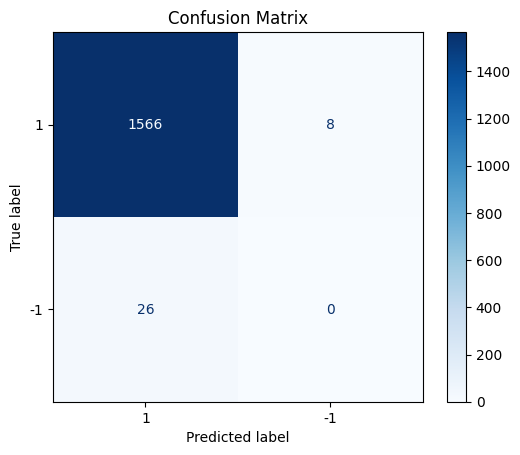

##############################
Test Evaluation
##############################
              precision    recall  f1-score   support

     Inliers       0.99      1.00      1.00       396
    Outliers       1.00      0.25      0.40         4

    accuracy                           0.99       400
   macro avg       1.00      0.62      0.70       400
weighted avg       0.99      0.99      0.99       400



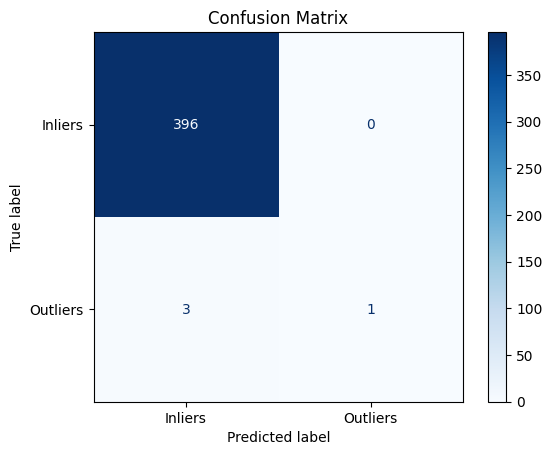

In [23]:
print("##############################")
print("Train Evaluation")
print("##############################")
# wider param grid, no smote
train_pred = best_clf.predict(X_train_scaled) 
print(classification_report(y_train_gs, train_pred)) 


conf_matrix = confusion_matrix(y_train_gs, train_pred, labels=[1, -1])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                display_labels=[1, -1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# (-1 for outliers, 1 for inliers)
print("##############################")
print("Test Evaluation")
print("##############################")

test_pred = best_clf.predict(X_test_scaled) 
labels = [1, -1]  # -1 for Outliers, 1 for Inliers

print(classification_report(y_true=y_test_gs, y_pred=test_pred,labels=labels, target_names=['Inliers', 'Outliers'])) 

conf_matrix = confusion_matrix(y_test_gs, test_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Inliers', 'Outliers'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Model training (no tuning)

In [9]:
# Create a One-Class SVM model
clf = OneClassSVM(nu=0.1) 
# Fit the model on the training data
clf.fit(X_train_scaled, y_train) 

OneClassSVM(nu=0.1)

##############################
Train Evaluation
##############################
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1574
           1       0.01      0.04      0.01        26

    accuracy                           0.88      1600
   macro avg       0.49      0.47      0.47      1600
weighted avg       0.97      0.88      0.92      1600



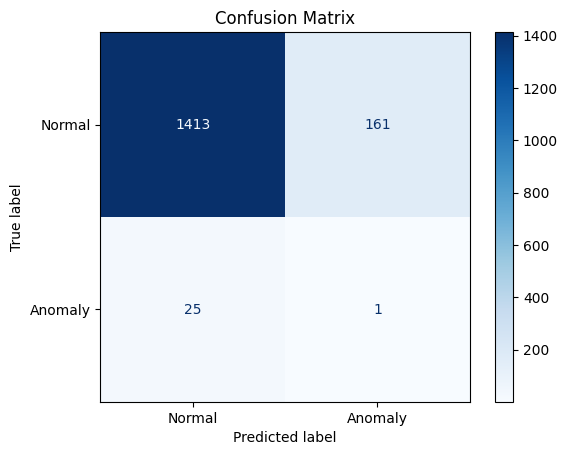


##############################
Test Evaluation
##############################
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       396
           1       0.02      0.25      0.04         4

    accuracy                           0.87       400
   macro avg       0.51      0.56      0.48       400
weighted avg       0.98      0.87      0.92       400



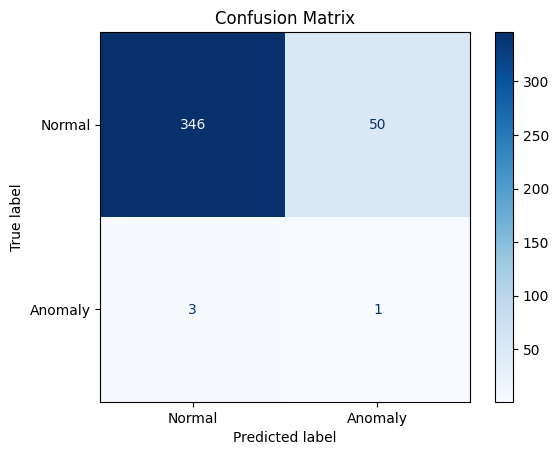

In [10]:

def eval_svm(preds, labels):

    # Convert predictions (-1 for outliers, 1 for inliers) to binary labels (0 for normal, 1 for anomaly)
    pred_labels = np.where(preds == -1, 1, 0)
    print(classification_report(labels, pred_labels))

    conf_matrix = confusion_matrix(labels, pred_labels)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                   display_labels=["Normal", "Anomaly"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

train_pred = clf.predict(X_train_scaled)
print("##############################")
print("Train Evaluation")
print("##############################")
eval_svm(train_pred, y_train)

print()

test_pred = clf.predict(X_test_scaled)
print("##############################")
print("Test Evaluation")
print("##############################")
eval_svm(test_pred, y_test)

## WITH SMOTE

In [26]:
# SMOTE
oversample = SMOTE(sampling_strategy = 0.3, random_state = 42) #sampling_strategy=0.8
resampled_X_train, resampled_y_train = oversample.fit_resample(X_train, y_train)

print("Train Labels after Resampling")
print(Counter(resampled_y_train))

Train Labels after Resampling
Counter({0: 1574, 1: 472})


In [27]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled_smote = scaler.fit_transform(resampled_X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
def make_binary_labels(labels):
    return np.where(labels == 1, -1, 1)

y_train_smote = make_binary_labels(resampled_y_train)
y_test_smote = make_binary_labels(y_test)

In [29]:
def custom_scorer(y_true, y_pred):
    # Compute confusion matrix
    fp = sum((y_true == 1) & (y_pred == -1))  # False Positives
    return precision_score(y_true,y_pred) - fp

# Create a scorer using make_scorer
scorer = make_scorer(custom_scorer, greater_is_better=True)

# defining parameter range 
param_grid = {
    'nu': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001, 1.0, 10.0]  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

smote_clf = GridSearchCV(OneClassSVM(), param_grid, refit = True, verbose = 3, scoring=scorer) 

# fitting the model for grid search 
smote_clf.fit(X_train_scaled_smote, y_train_smote) 

# print best parameter after tuning 
print(smote_clf.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(smote_clf.best_estimator_) 


Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV 1/5] END gamma=scale, kernel=linear, nu=0.001;, score=-164.004 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.001;, score=-180.022 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.001;, score=-205.010 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.001;, score=-115.068 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.005;, score=-146.019 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.005;, score=-290.026 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.005;, score=-100.016 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.005;, score=-333.286 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.01;, score=-205.010 total time=   0.

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END gamma=scale, kernel=linear, nu=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.3;, score=-358.000 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.3;, score=-296.009 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.3;, score=-345.017 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.3;, score=-342.160 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=linear, nu=0.3;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.5;, score=-371.000 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.5;, score=-354.020 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.5;, score=-317.000 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.5;, score=-343.048 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=linear, nu=0.5;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.7;, score=-354.000 total time=   0.0s
[

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END gamma=scale, kernel=sigmoid, nu=0.1;, score=-63.017 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=sigmoid, nu=0.1;, score=-55.017 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=sigmoid, nu=0.1;, score=-61.017 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=sigmoid, nu=0.1;, score=-52.126 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=sigmoid, nu=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=sigmoid, nu=0.2;, score=-113.020 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=sigmoid, nu=0.2;, score=-100.019 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=sigmoid, nu=0.2;, score=-123.021 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=sigmoid, nu=0.2;, score=-92.142 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=sigmoid, nu=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=sigmoid, nu=0.3;, score=-165.025 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=sigmoid, nu=0.3;, score=-158.020 total time

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END gamma=auto, kernel=linear, nu=0.5;, score=-354.020 total time=   0.0s
[CV 3/5] END gamma=auto, kernel=linear, nu=0.5;, score=-317.000 total time=   0.0s
[CV 4/5] END gamma=auto, kernel=linear, nu=0.5;, score=-343.048 total time=   0.0s
[CV 5/5] END .gamma=auto, kernel=linear, nu=0.5;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=auto, kernel=linear, nu=0.7;, score=-354.000 total time=   0.0s
[CV 2/5] END gamma=auto, kernel=linear, nu=0.7;, score=-310.011 total time=   0.0s
[CV 3/5] END gamma=auto, kernel=linear, nu=0.7;, score=-322.012 total time=   0.0s
[CV 4/5] END gamma=auto, kernel=linear, nu=0.7;, score=-186.111 total time=   0.0s
[CV 5/5] END .gamma=auto, kernel=linear, nu=0.7;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=auto, kernel=linear, nu=0.9;, score=-283.000 total time=   0.0s
[CV 2/5] END gamma=auto, kernel=linear, nu=0.9;, score=-357.000 total time=   0.0s
[CV 3/5] END gamma=auto, kernel=linear, nu=0.9;, score=-315.022 total time=   0.0s
[CV 4/5]

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END ...gamma=auto, kernel=poly, nu=0.9;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=auto, kernel=sigmoid, nu=0.001;, score=-2.015 total time=   0.0s
[CV 2/5] END gamma=auto, kernel=sigmoid, nu=0.001;, score=0.985 total time=   0.0s
[CV 3/5] END gamma=auto, kernel=sigmoid, nu=0.001;, score=-3.015 total time=   0.0s
[CV 4/5] END gamma=auto, kernel=sigmoid, nu=0.001;, score=0.890 total time=   0.0s
[CV 5/5] END gamma=auto, kernel=sigmoid, nu=0.001;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=auto, kernel=sigmoid, nu=0.005;, score=-1.015 total time=   0.0s
[CV 2/5] END gamma=auto, kernel=sigmoid, nu=0.005;, score=0.985 total time=   0.0s
[CV 3/5] END gamma=auto, kernel=sigmoid, nu=0.005;, score=-0.015 total time=   0.0s
[CV 4/5] END gamma=auto, kernel=sigmoid, nu=0.005;, score=-8.113 total time=   0.0s
[CV 5/5] END gamma=auto, kernel=sigmoid, nu=0.005;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=auto, kernel=sigmoid, nu=0.01;, score=-4.015 total time=   0.0s
[

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END gamma=0.1, kernel=linear, nu=0.3;, score=-296.009 total time=   0.0s
[CV 3/5] END gamma=0.1, kernel=linear, nu=0.3;, score=-345.017 total time=   0.0s
[CV 4/5] END gamma=0.1, kernel=linear, nu=0.3;, score=-342.160 total time=   0.0s
[CV 5/5] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.1, kernel=linear, nu=0.5;, score=-371.000 total time=   0.0s
[CV 2/5] END gamma=0.1, kernel=linear, nu=0.5;, score=-354.020 total time=   0.0s
[CV 3/5] END gamma=0.1, kernel=linear, nu=0.5;, score=-317.000 total time=   0.0s
[CV 4/5] END gamma=0.1, kernel=linear, nu=0.5;, score=-343.048 total time=   0.0s
[CV 5/5] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.1, kernel=linear, nu=0.7;, score=-354.000 total time=   0.0s
[CV 2/5] END gamma=0.1, kernel=linear, nu=0.7;, score=-310.011 total time=   0.0s
[CV 3/5] END gamma=0.1, kernel=linear, nu=0.7;, score=-322.012 total time=   0.0s
[CV 4/5] END gamma

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END ....gamma=0.1, kernel=poly, nu=0.9;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.1, kernel=sigmoid, nu=0.001;, score=-1.015 total time=   0.0s
[CV 2/5] END gamma=0.1, kernel=sigmoid, nu=0.001;, score=-1.015 total time=   0.0s
[CV 3/5] END gamma=0.1, kernel=sigmoid, nu=0.001;, score=-2.015 total time=   0.0s
[CV 4/5] END gamma=0.1, kernel=sigmoid, nu=0.001;, score=0.890 total time=   0.0s
[CV 5/5] END gamma=0.1, kernel=sigmoid, nu=0.001;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.1, kernel=sigmoid, nu=0.005;, score=-0.015 total time=   0.0s
[CV 2/5] END gamma=0.1, kernel=sigmoid, nu=0.005;, score=0.985 total time=   0.0s
[CV 3/5] END gamma=0.1, kernel=sigmoid, nu=0.005;, score=-2.015 total time=   0.0s
[CV 4/5] END gamma=0.1, kernel=sigmoid, nu=0.005;, score=-3.111 total time=   0.0s
[CV 5/5] END gamma=0.1, kernel=sigmoid, nu=0.005;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.1, kernel=sigmoid, nu=0.01;, score=0.985 total time=   0.0s
[CV 2/5] END

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.01, kernel=linear, nu=0.3;, score=-358.000 total time=   0.0s
[CV 2/5] END gamma=0.01, kernel=linear, nu=0.3;, score=-296.009 total time=   0.0s
[CV 3/5] END gamma=0.01, kernel=linear, nu=0.3;, score=-345.017 total time=   0.0s
[CV 4/5] END gamma=0.01, kernel=linear, nu=0.3;, score=-342.160 total time=   0.0s
[CV 5/5] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.01, kernel=linear, nu=0.5;, score=-371.000 total time=   0.0s
[CV 2/5] END gamma=0.01, kernel=linear, nu=0.5;, score=-354.020 total time=   0.0s
[CV 3/5] END gamma=0.01, kernel=linear, nu=0.5;, score=-317.000 total time=   0.0s
[CV 4/5] END gamma=0.01, kernel=linear, nu=0.5;, score=-343.048 total time=   0.0s
[CV 5/5] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.01, kernel=linear, nu=0.7;, score=-354.000 total time=   0.0s
[CV 2/5] E

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END gamma=0.01, kernel=sigmoid, nu=0.005;, score=-10.015 total time=   0.0s
[CV 4/5] END gamma=0.01, kernel=sigmoid, nu=0.005;, score=-5.112 total time=   0.0s
[CV 5/5] END gamma=0.01, kernel=sigmoid, nu=0.005;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.01, kernel=sigmoid, nu=0.01;, score=-7.015 total time=   0.0s
[CV 2/5] END gamma=0.01, kernel=sigmoid, nu=0.01;, score=-3.015 total time=   0.0s
[CV 3/5] END gamma=0.01, kernel=sigmoid, nu=0.01;, score=-11.015 total time=   0.0s
[CV 4/5] END gamma=0.01, kernel=sigmoid, nu=0.01;, score=-5.112 total time=   0.0s
[CV 5/5] END gamma=0.01, kernel=sigmoid, nu=0.01;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.01, kernel=sigmoid, nu=0.05;, score=-39.016 total time=   0.0s
[CV 2/5] END gamma=0.01, kernel=sigmoid, nu=0.05;, score=-19.015 total time=   0.0s
[CV 3/5] END gamma=0.01, kernel=sigmoid, nu=0.05;, score=-36.016 total time=   0.0s
[CV 4/5] END gamma=0.01, kernel=sigmoid, nu=0.05;, score=-21.114 total time=   0.

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END gamma=0.001, kernel=linear, nu=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=linear, nu=0.3;, score=-358.000 total time=   0.0s
[CV 2/5] END gamma=0.001, kernel=linear, nu=0.3;, score=-296.009 total time=   0.0s
[CV 3/5] END gamma=0.001, kernel=linear, nu=0.3;, score=-345.017 total time=   0.0s
[CV 4/5] END gamma=0.001, kernel=linear, nu=0.3;, score=-342.160 total time=   0.0s
[CV 5/5] END gamma=0.001, kernel=linear, nu=0.3;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=linear, nu=0.5;, score=-371.000 total time=   0.0s
[CV 2/5] END gamma=0.001, kernel=linear, nu=0.5;, score=-354.020 total time=   0.0s
[CV 3/5] END gamma=0.001, kernel=linear, nu=0.5;, score=-317.000 total time=   0.0s
[CV 4/5] END gamma=0.001, kernel=linear, nu=0.5;, score=-343.048 total time=   0.0s
[CV 5/5] END gamma=0.001, kernel=linear, nu=0.5;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=linear, nu=0.7;, score=-354.000 total time=   0.0s
[

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END gamma=0.001, kernel=poly, nu=0.2;, score=-126.004 total time=   0.0s
[CV 2/5] END gamma=0.001, kernel=poly, nu=0.2;, score=-91.013 total time=   0.0s
[CV 3/5] END gamma=0.001, kernel=poly, nu=0.2;, score=-64.009 total time=   0.0s
[CV 4/5] END gamma=0.001, kernel=poly, nu=0.2;, score=-71.073 total time=   0.0s
[CV 5/5] END ..gamma=0.001, kernel=poly, nu=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=poly, nu=0.3;, score=-183.000 total time=   0.0s
[CV 2/5] END gamma=0.001, kernel=poly, nu=0.3;, score=-363.025 total time=   0.0s
[CV 3/5] END gamma=0.001, kernel=poly, nu=0.3;, score=-129.007 total time=   0.0s
[CV 4/5] END gamma=0.001, kernel=poly, nu=0.3;, score=-137.050 total time=   0.0s
[CV 5/5] END ..gamma=0.001, kernel=poly, nu=0.3;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=poly, nu=0.5;, score=-376.000 total time=   0.0s
[CV 2/5] END gamma=0.001, kernel=poly, nu=0.5;, score=-387.000 total time=   0.0s
[CV 3/5] END gamma=0.

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END gamma=0.0001, kernel=linear, nu=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=linear, nu=0.3;, score=-358.000 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=linear, nu=0.3;, score=-296.009 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=linear, nu=0.3;, score=-345.017 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=linear, nu=0.3;, score=-342.160 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=linear, nu=0.3;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=linear, nu=0.5;, score=-371.000 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=linear, nu=0.5;, score=-354.020 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=linear, nu=0.5;, score=-317.000 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=linear, nu=0.5;, score=-343.048 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=linear, nu=0.5;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=linear, nu=0.7;, score=-354.000 total ti

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END .gamma=0.0001, kernel=poly, nu=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=poly, nu=0.2;, score=-38.011 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=poly, nu=0.2;, score=-73.009 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=poly, nu=0.2;, score=-78.018 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=poly, nu=0.2;, score=-79.104 total time=   0.0s
[CV 5/5] END .gamma=0.0001, kernel=poly, nu=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=poly, nu=0.3;, score=-372.000 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=poly, nu=0.3;, score=-375.036 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=poly, nu=0.3;, score=-84.015 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=poly, nu=0.3;, score=-81.084 total time=   0.0s
[CV 5/5] END .gamma=0.0001, kernel=poly, nu=0.3;, score=0.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END gamma=0.0001, kernel=poly, nu=0.5;, score=-404.000 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=poly, nu=0.5;, score=-27.013 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=poly, nu=0.5;, score=-190.005 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=poly, nu=0.5;, score=-198.057 total time=   0.0s
[CV 5/5] END .gamma=0.0001, kernel=poly, nu=0.5;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=poly, nu=0.7;, score=-292.000 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=poly, nu=0.7;, score=-184.014 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=poly, nu=0.7;, score=-200.005 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=poly, nu=0.7;, score=-216.058 total time=   0.0s
[CV 5/5] END .gamma=0.0001, kernel=poly, nu=0.7;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=poly, nu=0.9;, score=-233.000 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=poly, nu=0.9;, score=-171.017 total time=   0.0s
[CV 3/5] 

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END gamma=0.0001, kernel=sigmoid, nu=0.1;, score=-358.000 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=sigmoid, nu=0.1;, score=-331.086 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=sigmoid, nu=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=sigmoid, nu=0.2;, score=-367.000 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=sigmoid, nu=0.2;, score=-356.000 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=sigmoid, nu=0.2;, score=-326.000 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=sigmoid, nu=0.2;, score=-319.000 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=sigmoid, nu=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=sigmoid, nu=0.3;, score=-383.000 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=sigmoid, nu=0.3;, score=-357.022 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=sigmoid, nu=0.3;, score=-275.000 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=sigmoid, nu=0.3;, score=-3

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END gamma=0.0001, kernel=sigmoid, nu=0.5;, score=-344.017 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=sigmoid, nu=0.5;, score=-332.061 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=sigmoid, nu=0.5;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=sigmoid, nu=0.7;, score=-279.000 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=sigmoid, nu=0.7;, score=-339.016 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=sigmoid, nu=0.7;, score=-372.000 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=sigmoid, nu=0.7;, score=-338.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END gamma=0.0001, kernel=sigmoid, nu=0.7;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=sigmoid, nu=0.9;, score=-384.000 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=sigmoid, nu=0.9;, score=-329.000 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=sigmoid, nu=0.9;, score=-220.022 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=sigmoid, nu=0.9;, score=-354.000 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=sigmoid, nu=0.9;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=1.0, kernel=linear, nu=0.001;, score=-164.004 total time=   0.0s
[CV 2/5] END gamma=1.0, kernel=linear, nu=0.001;, score=-180.022 total time=   0.0s
[CV 3/5] END gamma=1.0, kernel=linear, nu=0.001;, score=-205.010 total time=   0.0s
[CV 4/5] END gamma=1.0, kernel=linear, nu=0.001;, score=-115.068 total time=   0.0s
[CV 5/5] END gamma=1.0, kernel=linear, nu=0.001;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=1.0, kernel=linear, nu=0.005;, score=-146.019 total ti

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END gamma=1.0, kernel=linear, nu=0.3;, score=-296.009 total time=   0.0s
[CV 3/5] END gamma=1.0, kernel=linear, nu=0.3;, score=-345.017 total time=   0.0s
[CV 4/5] END gamma=1.0, kernel=linear, nu=0.3;, score=-342.160 total time=   0.0s
[CV 5/5] END ..gamma=1.0, kernel=linear, nu=0.3;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=1.0, kernel=linear, nu=0.5;, score=-371.000 total time=   0.0s
[CV 2/5] END gamma=1.0, kernel=linear, nu=0.5;, score=-354.020 total time=   0.0s
[CV 3/5] END gamma=1.0, kernel=linear, nu=0.5;, score=-317.000 total time=   0.0s
[CV 4/5] END gamma=1.0, kernel=linear, nu=0.5;, score=-343.048 total time=   0.0s
[CV 5/5] END ..gamma=1.0, kernel=linear, nu=0.5;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=1.0, kernel=linear, nu=0.7;, score=-354.000 total time=   0.0s
[CV 2/5] END gamma=1.0, kernel=linear, nu=0.7;, score=-310.011 total time=   0.0s
[CV 3/5] END gamma=1.0, kernel=linear, nu=0.7;, score=-322.012 total time=   0.0s
[CV 4/5] END gamma

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END gamma=1.0, kernel=sigmoid, nu=0.05;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=1.0, kernel=sigmoid, nu=0.1;, score=-29.013 total time=   0.0s
[CV 2/5] END gamma=1.0, kernel=sigmoid, nu=0.1;, score=-56.017 total time=   0.0s
[CV 3/5] END gamma=1.0, kernel=sigmoid, nu=0.1;, score=-41.016 total time=   0.0s
[CV 4/5] END gamma=1.0, kernel=sigmoid, nu=0.1;, score=-45.124 total time=   0.0s
[CV 5/5] END .gamma=1.0, kernel=sigmoid, nu=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=1.0, kernel=sigmoid, nu=0.2;, score=-71.009 total time=   0.0s
[CV 2/5] END gamma=1.0, kernel=sigmoid, nu=0.2;, score=-85.012 total time=   0.0s
[CV 3/5] END gamma=1.0, kernel=sigmoid, nu=0.2;, score=-85.016 total time=   0.0s
[CV 4/5] END gamma=1.0, kernel=sigmoid, nu=0.2;, score=-87.132 total time=   0.0s
[CV 5/5] END .gamma=1.0, kernel=sigmoid, nu=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=1.0, kernel=sigmoid, nu=0.3;, score=-112.010 total time=   0.0s
[CV 2/5] END gamma

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END gamma=10.0, kernel=linear, nu=0.3;, score=-358.000 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=linear, nu=0.3;, score=-296.009 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=linear, nu=0.3;, score=-345.017 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=linear, nu=0.3;, score=-342.160 total time=   0.0s
[CV 5/5] END .gamma=10.0, kernel=linear, nu=0.3;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=linear, nu=0.5;, score=-371.000 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=linear, nu=0.5;, score=-354.020 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=linear, nu=0.5;, score=-317.000 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=linear, nu=0.5;, score=-343.048 total time=   0.0s
[CV 5/5] END .gamma=10.0, kernel=linear, nu=0.5;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=linear, nu=0.7;, score=-354.000 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=linear, nu=0.7;, score=-310.011 total time=   0.0s
[CV 3/5]

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END gamma=10.0, kernel=rbf, nu=0.001;, score=-403.000 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=rbf, nu=0.001;, score=-403.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END gamma=10.0, kernel=rbf, nu=0.001;, score=-364.000 total time=   0.0s
[CV 5/5] END ..gamma=10.0, kernel=rbf, nu=0.001;, score=0.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END gamma=10.0, kernel=rbf, nu=0.005;, score=-404.000 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=rbf, nu=0.005;, score=-403.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END gamma=10.0, kernel=rbf, nu=0.005;, score=-403.000 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=rbf, nu=0.005;, score=-364.000 total time=   0.0s
[CV 5/5] END ..gamma=10.0, kernel=rbf, nu=0.005;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=rbf, nu=0.01;, score=-404.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END gamma=10.0, kernel=rbf, nu=0.01;, score=-403.000 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=rbf, nu=0.01;, score=-403.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END gamma=10.0, kernel=rbf, nu=0.01;, score=-364.000 total time=   0.0s
[CV 5/5] END ...gamma=10.0, kernel=rbf, nu=0.01;, score=0.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END gamma=10.0, kernel=rbf, nu=0.05;, score=-404.000 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=rbf, nu=0.05;, score=-403.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END gamma=10.0, kernel=rbf, nu=0.05;, score=-403.000 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=rbf, nu=0.05;, score=-364.000 total time=   0.0s
[CV 5/5] END ...gamma=10.0, kernel=rbf, nu=0.05;, score=0.000 total time=   0.0s
[CV 1/5] END .gamma=10.0, kernel=rbf, nu=0.1;, score=-404.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END .gamma=10.0, kernel=rbf, nu=0.1;, score=-403.000 total time=   0.0s
[CV 3/5] END .gamma=10.0, kernel=rbf, nu=0.1;, score=-403.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END .gamma=10.0, kernel=rbf, nu=0.1;, score=-364.000 total time=   0.0s
[CV 5/5] END ....gamma=10.0, kernel=rbf, nu=0.1;, score=0.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END .gamma=10.0, kernel=rbf, nu=0.2;, score=-404.000 total time=   0.0s
[CV 2/5] END .gamma=10.0, kernel=rbf, nu=0.2;, score=-403.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END .gamma=10.0, kernel=rbf, nu=0.2;, score=-403.000 total time=   0.0s
[CV 4/5] END .gamma=10.0, kernel=rbf, nu=0.2;, score=-364.000 total time=   0.0s
[CV 5/5] END ....gamma=10.0, kernel=rbf, nu=0.2;, score=0.000 total time=   0.1s
[CV 1/5] END .gamma=10.0, kernel=rbf, nu=0.3;, score=-404.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END .gamma=10.0, kernel=rbf, nu=0.3;, score=-403.000 total time=   0.0s
[CV 3/5] END .gamma=10.0, kernel=rbf, nu=0.3;, score=-403.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END .gamma=10.0, kernel=rbf, nu=0.3;, score=-364.000 total time=   0.0s
[CV 5/5] END ....gamma=10.0, kernel=rbf, nu=0.3;, score=0.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END .gamma=10.0, kernel=rbf, nu=0.5;, score=-404.000 total time=   0.0s
[CV 2/5] END .gamma=10.0, kernel=rbf, nu=0.5;, score=-403.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END .gamma=10.0, kernel=rbf, nu=0.5;, score=-403.000 total time=   0.0s
[CV 4/5] END .gamma=10.0, kernel=rbf, nu=0.5;, score=-364.000 total time=   0.0s
[CV 5/5] END ....gamma=10.0, kernel=rbf, nu=0.5;, score=0.000 total time=   0.0s
[CV 1/5] END .gamma=10.0, kernel=rbf, nu=0.7;, score=-404.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END .gamma=10.0, kernel=rbf, nu=0.7;, score=-403.000 total time=   0.0s
[CV 3/5] END .gamma=10.0, kernel=rbf, nu=0.7;, score=-403.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END .gamma=10.0, kernel=rbf, nu=0.7;, score=-364.000 total time=   0.0s
[CV 5/5] END ....gamma=10.0, kernel=rbf, nu=0.7;, score=0.000 total time=   0.1s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END .gamma=10.0, kernel=rbf, nu=0.9;, score=-404.000 total time=   0.0s
[CV 2/5] END .gamma=10.0, kernel=rbf, nu=0.9;, score=-403.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END .gamma=10.0, kernel=rbf, nu=0.9;, score=-403.000 total time=   0.0s
[CV 4/5] END .gamma=10.0, kernel=rbf, nu=0.9;, score=-364.000 total time=   0.0s
[CV 5/5] END ....gamma=10.0, kernel=rbf, nu=0.9;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=poly, nu=0.001;, score=-42.014 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=poly, nu=0.001;, score=-44.016 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=poly, nu=0.001;, score=-60.017 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=poly, nu=0.001;, score=-41.108 total time=   0.0s
[CV 5/5] END .gamma=10.0, kernel=poly, nu=0.001;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=poly, nu=0.005;, score=-47.014 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=poly, nu=0.005;, score=-45.017 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=poly, nu=0.005;, score=-59.017 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=poly, nu=0.005;, score=-40.105 total time=   0.0s
[CV 5/5] END .gamma=

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END gamma=10.0, kernel=sigmoid, nu=0.1;, score=-33.011 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=sigmoid, nu=0.1;, score=-53.017 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=sigmoid, nu=0.1;, score=-47.017 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=sigmoid, nu=0.1;, score=-44.124 total time=   0.0s
[CV 5/5] END gamma=10.0, kernel=sigmoid, nu=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=sigmoid, nu=0.2;, score=-68.009 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=sigmoid, nu=0.2;, score=-90.010 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=sigmoid, nu=0.2;, score=-80.015 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=sigmoid, nu=0.2;, score=-77.123 total time=   0.0s
[CV 5/5] END gamma=10.0, kernel=sigmoid, nu=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=sigmoid, nu=0.3;, score=-106.010 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=sigmoid, nu=0.3;, score=-134.011 total time=   0.0s
[CV 3/

##############################
Train Evaluation
##############################
              precision    recall  f1-score   support

     Inliers       0.77      1.00      0.87      1574
    Outliers       0.00      0.00      0.00       472

    accuracy                           0.77      2046
   macro avg       0.38      0.50      0.43      2046
weighted avg       0.59      0.77      0.67      2046



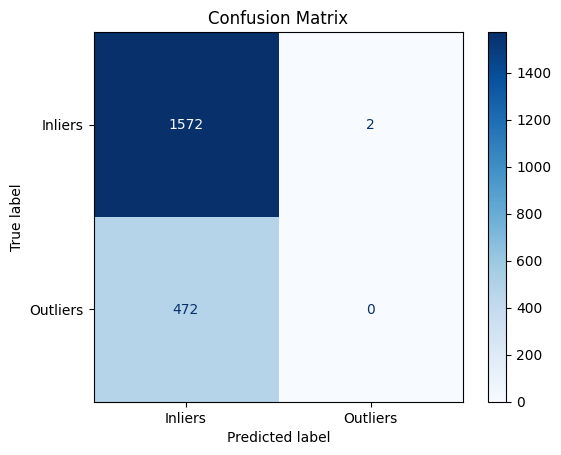

##############################
Test Evaluation
##############################
              precision    recall  f1-score   support

     Inliers       0.99      1.00      0.99       396
    Outliers       0.00      0.00      0.00         4

    accuracy                           0.99       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.98      0.99      0.99       400



c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

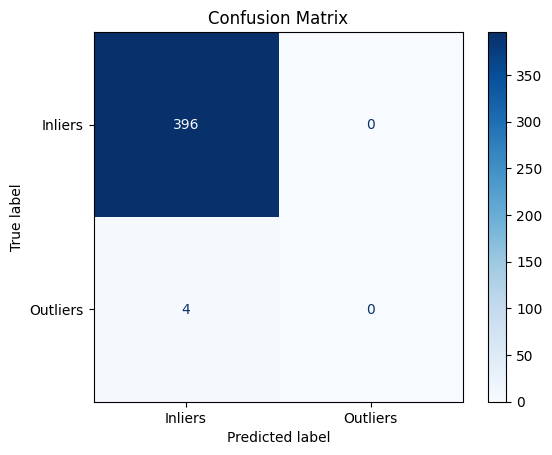

In [30]:
# wider param grid, smote
print("##############################")
print("Train Evaluation")
print("##############################")
smote_train_pred = smote_clf.predict(X_train_scaled_smote) 

labels = [1, -1]  # -1 for Outliers, 1 for Inliers
print(classification_report(y_true=y_train_smote, y_pred=smote_train_pred,labels=labels, target_names=['Inliers', 'Outliers'])) 

conf_matrix = confusion_matrix(y_train_smote, smote_train_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                display_labels=['Inliers', 'Outliers'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print("##############################")
print("Test Evaluation")
print("##############################")

smote_test_pred = smote_clf.predict(X_test_scaled) 

print(classification_report(y_true=y_test_smote, y_pred=smote_test_pred,labels=labels, target_names=['Inliers', 'Outliers'])) 

conf_matrix = confusion_matrix(y_test_smote, smote_test_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                display_labels=['Inliers', 'Outliers'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Risk scores

In [15]:
def get_risk_score(clf, X):
    def min_max_scaling(value, new_min, new_max):
        old_min = min(value)
        old_max = max(value)
        scaled_value = ((value - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min
        return scaled_value
    
    # distance from decision boundary where negative = non anomaly and positive = anomaly
    distances = clf.decision_function(X)
    risk_scores = min_max_scaling(distances, -1,1)
    
    return risk_scores


In [16]:
train_risk = get_risk_score(best_clf, X_train_scaled)
test_risk = get_risk_score(best_clf, X_test_scaled)

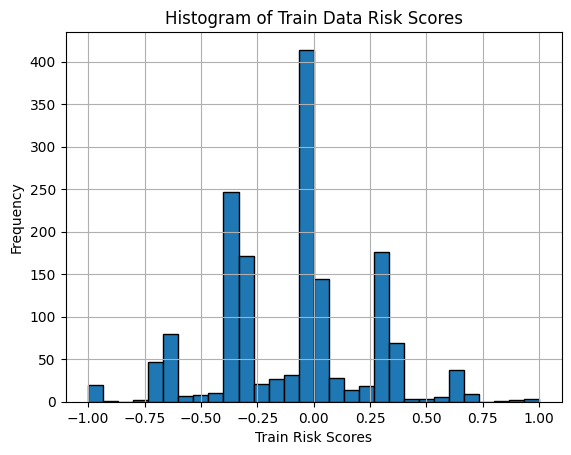

In [17]:
# Plot histogram
plt.hist(train_risk, bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Train Risk Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Train Data Risk Scores')
plt.grid(True)
plt.show()

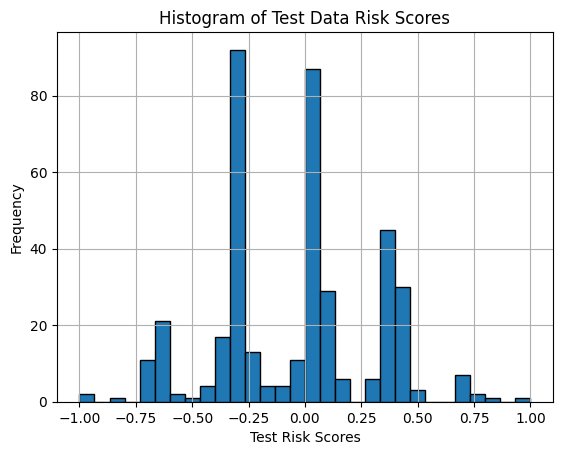

In [18]:
import matplotlib.pyplot as plt
# Plot histogram
plt.hist(test_risk, bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Test Risk Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Test Data Risk Scores')
plt.grid(True)
plt.show()

In [19]:
print("Example Train Risk Scores:")
print(train_risk[:10])  
print("\nExample Test Risk Scores:")
print(test_risk[:10])

Example Train Risk Scores:
[-0.65403703 -0.32256257 -0.0517448  -0.02032487  0.35945298 -0.69463912
  0.28329003 -0.32144926  0.35415059 -0.01628515]

Example Test Risk Scores:
[ 0.75738716 -0.67409111 -0.28042474  0.07983322  0.03989024  0.03775803
  0.00332596 -0.34844985 -0.31595053  0.04900708]


## ROC AUC

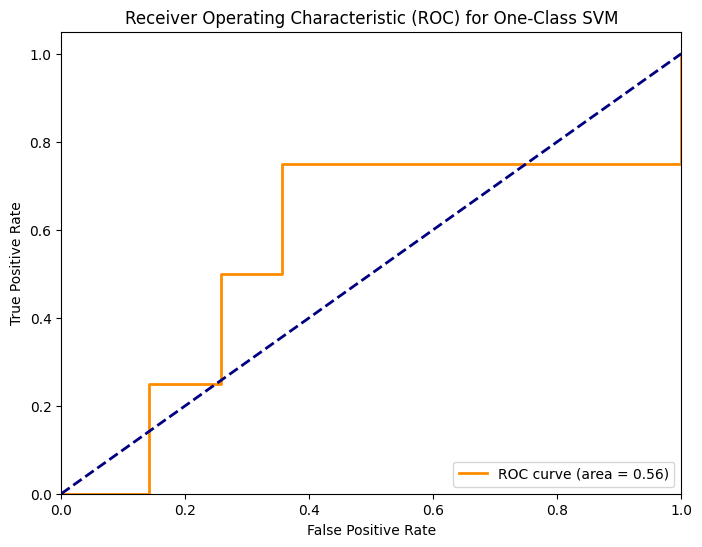

In [21]:
def plot_roc(clf):
    # Decision function scores (distances to the separating hyperplane)
    scores = clf.decision_function(X_test_scaled)
    
    # Rescale the scores to range [0, 1]
    scores_rescaled = (scores - scores.min()) / (scores.max() - scores.min())

    # # Invert the scores, because One-Class SVM assigns negative scores to inliers
    # scores_rescaled = 1 - scores_rescaled

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, scores_rescaled)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for One-Class SVM')
    plt.legend(loc="lower right")
    plt.show()

plot_roc(best_clf)

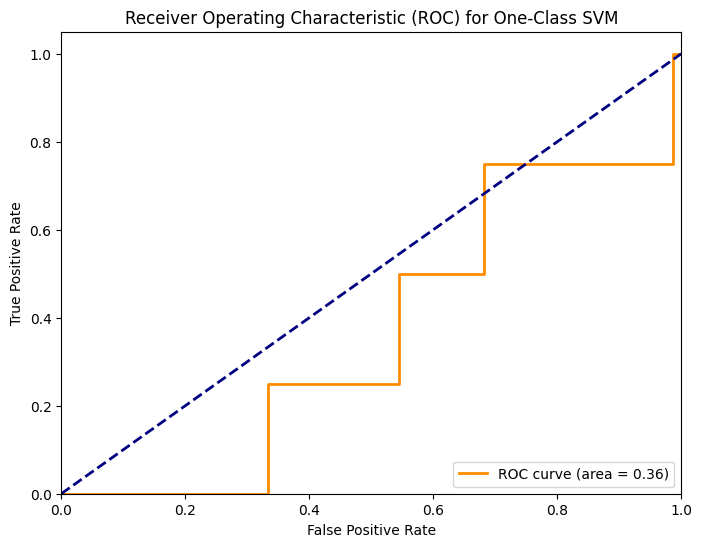

In [31]:
plot_roc(smote_clf)

## Export CSV of FP,FN,TP names for entire dataset

In [24]:
train_pred = np.where(train_pred == -1, 1, 0)
test_pred = np.where(test_pred == -1, 1, 0)

In [25]:
# Filter out empty entries before concatenating
fp_train_names = X_train_w_name.iloc[np.where((y_train == 0) & (train_pred == 1))[0]]["user"]
fp_test_names = X_test_w_name.iloc[np.where((y_test == 0) & (test_pred == 1))[0]]["user"]

fn_train_names = X_train_w_name.iloc[np.where((y_train == 1) & (train_pred == 0))[0]]["user"]
fn_test_names = X_test_w_name.iloc[np.where((y_test == 1) & (test_pred == 0))[0]]["user"]

tp_train_names = X_train_w_name.iloc[np.where((y_train == 1) & (train_pred == 1))[0]]["user"]
tp_test_names = X_test_w_name.iloc[np.where((y_test == 1) & (test_pred == 1))[0]]["user"]

# Concatenate false positives and false negatives dataframes
fp_names = pd.concat([fp_train_names, fp_test_names], ignore_index=True)
fn_names = pd.concat([fn_train_names, fn_test_names], ignore_index=True)
tp_names = pd.concat([tp_train_names, tp_test_names], ignore_index=True)

# Create a dictionary with fp and fn dataframes
data = {'False Positives': fp_names, 'False Negatives': fn_names, 'True Positives': tp_names}

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Export the DataFrame to a CSV file
df.to_csv('minority_users_svm.csv', index=False)